# TLUs in Concrete ML: Step-by-Step Analysis
This notebook investigates how quantization and activation function approximation affect neural network behavior in Fully Homomorphic Encryption (FHE) models compiled with Concrete ML.

Table Lookup Units (TLUs) are extracted during model compilation and compared to their original activation functions to better understand how these transformations impact the model's behavior and accuracy.


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from concrete.ml.sklearn import NeuralNetClassifier
import importlib
import concrete.fhe.mlir.utils as utils
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Ensure reproducibility
np.random.seed(0)

## Load and Prepare Data

We use the Iris dataset as a simple, well-behaved classification benchmark with low dimensionality (4 features) and clear class separability. This makes it ideal for analyzing the effects of quantization and activation approximations in isolation.

To prepare the data we standardize all features using `StandardScaler()` to ensure zero mean and unit variance. This improves neural network training stability and ensures consistent input ranges across features.


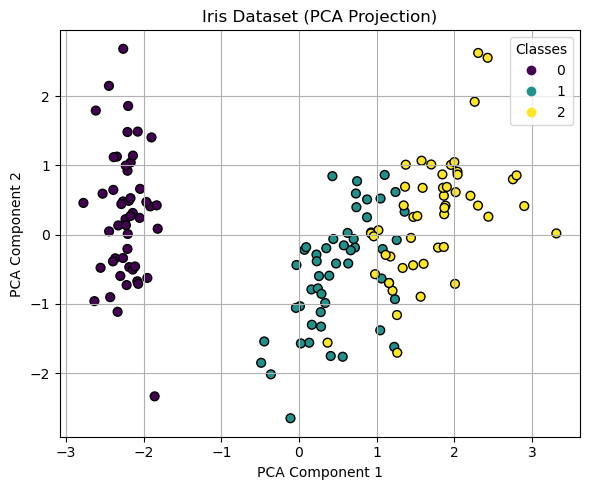

In [2]:
X, y = load_iris(return_X_y=True)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Iris Dataset (PCA Projection)')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid(True)
plt.tight_layout()
plt.show()


## Baseline Model

We define a simple feedforward neural network (`MyNet`) with a configurable number of layers and a shared activation function. For this baseline, we use the `Sigmoid` activation to match the functions used later in the Concrete-ML model.

This float32 model serves as the **reference point** for accuracy, against which we compare all quantized and approximated versions. It is trained using standard PyTorch tools and data in full precision.

Key design notes:
- `n_layers` refers to the **total number of linear layers**, including the final output layer.
- A shared activation function (in this case, `nn.Sigmoid`) is applied after each hidden layer.
- The model is trained using cross-entropy loss and Adam optimizer over 200 epochs.


In [3]:
# Standard feedforward network with a shared activation function across layers
class MyNet(nn.Module):
    def __init__(self, input_size=4, hidden_size=20, output_size=3, n_layers=3, activation_fn=nn.Sigmoid):
        super().__init__()
        layers = []

        # First layer: input → hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(activation_fn())

        # Intermediate hidden layers: hidden → hidden
        for _ in range(n_layers - 2):  # n_layers includes output, so subtract 2 here
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation_fn())

        # Final layer: hidden → output
        layers.append(nn.Linear(hidden_size, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [4]:
# Train a float32 model with standard sigmoid activations
float_model = MyNet(activation_fn=nn.Sigmoid)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(float_model.parameters(), lr=0.01)

X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)

for epoch in range(200):
    optimizer.zero_grad()
    output = float_model(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

In [5]:
# Evaluate float32 model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

float_preds = float_model(X_test_tensor).argmax(dim=1).numpy()
acc = accuracy_score(y_test, float_preds) * 100
print(f"Float32 Accuracy: {acc:.2f}%")

Float32 Accuracy: 100.00%


## Previous steps needed for inference with the FHE model

Includes diagnostic tools for analyzing Table Lookup Units (TLUs) generated during the compilation of neural networks in Concrete-ML. It includes:

- A utility to infer logical input domains based on TLU bit-width and quantization scale.  
- A `TLUCollector` class to store extracted TLUs and their associated metadata.  
- A patching mechanism that overrides Concrete-ML’s internal table construction logic to capture TLUs and print diagnostic statistics during model compilation.  
- A post-compilation plotting function that compares TLU outputs to standard and inverted sigmoid functions to assess approximation quality and detect input inversions.  


In [6]:
# Collector for TLU data during compilation
class TLUCollector:
    def __init__(self):
        self.tables = []
        self.input_ranges = []
        self.bit_widths = []

    def add(self, table, input_range, bit_width):
        self.tables.append(table)
        self.input_ranges.append(input_range)
        self.bit_widths.append(bit_width)

    def get_tlus(self):
        return [
            {"table": t, "input_range": r}
            for t, r in zip(self.tables, self.input_ranges)
        ]
        

In [7]:
# Patch Concrete-ML internals to log and collect TLUs during compilation
def patch_construct_table_with_diagnostics(collector):
    import concrete.fhe.mlir.utils as utils
    original = utils.construct_table

    def custom_construct_table(node, preds, config):
        table = original(node, preds, config)

        is_subgraph = (
            node.operation.name == "Generic"
            and "subgraph" in node.properties.get("kwargs", {})
        )
        if not is_subgraph:
            return table

        table_np = np.asarray(table)
        table_len = len(table_np)
        bit_width = int(np.log2(table_len))
        half_range = 2 ** (bit_width - 1)
        input_range = (-half_range, half_range - 1)

        collector.add(table_np, input_range, bit_width)

        # Basic statistics on TLU content
        print("\n--- TLU Construction Analysis ---")
        print(f"Captured TLU with {table_len} entries")
        print(f"Input range: {input_range}")
        print(f"Bit width: {bit_width} bits")
        print(f"Value range: min={table_np.min():.4f}, max={table_np.max():.4f}, unique={np.unique(table_np).size}")

        deltas = np.diff(table_np)
        print(f"Delta range: min={deltas.min():.4f}, max={deltas.max():.4f}")
        print(f"Monotonic increasing: {np.all(deltas >= 0)}")
        print(f"Monotonic decreasing: {np.all(deltas <= 0)}")

        return table

    utils.construct_table = custom_construct_table


In [8]:
# Post-compilation utility to plot TLU vs sigmoid
def plot_tlu_vs_sigmoid(tlu):
    table = np.array(tlu["table"], dtype=np.float32)
    input_range = tlu["input_range"]
    n = len(table)

    # Estimate scale from input_range
    logical_inputs = np.linspace(input_range[0], input_range[1], n)
    
    print("\nTLU Plot Summary:")
    print(f"Unscaled input range: {input_range}")
    print(f"Scaled input range: [{logical_inputs.min():.2f}, {logical_inputs.max():.2f}]")

    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    sig = sigmoid(logical_inputs)
    sig_inv = sigmoid(-logical_inputs)
    table_norm = (table - table.min()) / (table.ptp() + 1e-9)

    corr = np.corrcoef(sig, table_norm)[0, 1]
    corr_inv = np.corrcoef(sig_inv, table_norm)[0, 1]

    print(f"Correlation with sigmoid(x):  {corr:.4f}")
    print(f"Correlation with sigmoid(-x): {corr_inv:.4f}")

    plt.figure(figsize=(8, 4))
    plt.plot(logical_inputs, sig, '--', label="sigmoid(x)", color="black")
    plt.plot(logical_inputs, sig_inv, '--', label="sigmoid(-x)", color="gray")
    plt.plot(logical_inputs, table_norm, label="TLU Output (normalized)", color="blue")
    plt.title("TLU Output vs Sigmoid")
    plt.xlabel("Input domain (logical units)")
    plt.ylabel("Normalized Output")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## FHE Model

Train and compile a neural network using Concrete-ML, then extract and analyze the resulting Table Lookup Units (TLUs)


--- TLU Construction Analysis ---
Captured TLU with 128 entries
Input range: (-64, 63)
Bit width: 7 bits
Value range: min=0.0000, max=7.0000, unique=8
Delta range: min=-7.0000, max=1.0000
Monotonic increasing: False
Monotonic decreasing: False

--- TLU Construction Analysis ---
Captured TLU with 1024 entries
Input range: (-512, 511)
Bit width: 10 bits
Value range: min=0.0000, max=7.0000, unique=8
Delta range: min=-7.0000, max=1.0000
Monotonic increasing: False
Monotonic decreasing: False

--- TLU Construction Analysis ---
Captured TLU with 128 entries
Input range: (-64, 63)
Bit width: 7 bits
Value range: min=0.0000, max=7.0000, unique=8
Delta range: min=-7.0000, max=1.0000
Monotonic increasing: False
Monotonic decreasing: False

--- TLU Construction Analysis ---
Captured TLU with 128 entries
Input range: (-64, 63)
Bit width: 7 bits
Value range: min=0.0000, max=7.0000, unique=8
Delta range: min=-7.0000, max=1.0000
Monotonic increasing: False
Monotonic decreasing: False

--- TLU Constru

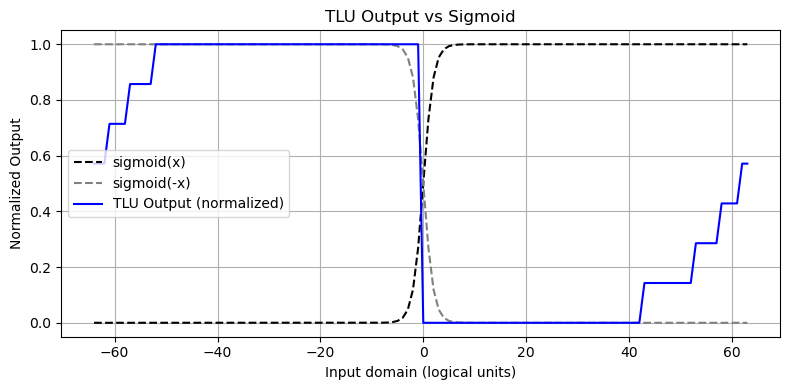


TLU Plot Summary:
Unscaled input range: (-512, 511)
Scaled input range: [-512.00, 511.00]
Correlation with sigmoid(x):  -0.9764
Correlation with sigmoid(-x): 0.9764


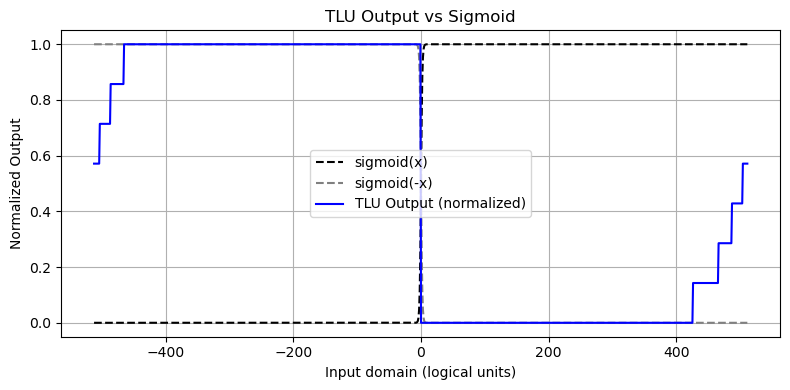

In [24]:
# Train a Concrete ML model and extract TLUs
fhe_model = NeuralNetClassifier(
    module__n_layers=3,
    module__n_hidden_neurons_multiplier=5.0,
    module__activation_function=nn.Sigmoid,
    optimizer=torch.optim.Adam,
    lr=0.01,
    max_epochs=200,
    verbose=0,
)

# Train and compile model once to get quantizer
fhe_model.fit(X_train, y_train)
fhe_model.compile(X_train)

# Create collector and patch for logging
collector = TLUCollector()
patch_construct_table_with_diagnostics(collector)

# Recompile to trigger TLU construction and diagnostics
fhe_model.compile(X_train)

# Get TLUs and plot them using the real scale
captured_tlus = collector.get_tlus()
for tlu in captured_tlus:
    plot_tlu_vs_sigmoid(tlu)


In [25]:
# Evaluate model in simulated FHE mode (quantized + TLUs, no encryption)
fhe_simulated_preds = fhe_model.predict(X_test, fhe="simulate")
acc_sim = accuracy_score(y_test, fhe_simulated_preds) * 100
print(f"Simulated FHE Accuracy: {acc_sim:.2f}%")

Simulated FHE Accuracy: 100.00%


## Previous steps needed for inference with the TLUs-only Model

Define a custom PyTorch architecture that replaces standard activation functions with Table Lookup Units (TLUs) extracted from a compiled Concrete-ML model:

- `MyNet_TLUs`: A feedforward neural network that accepts a list of TLU-based activation functions, applied layer-wise.
- `make_tlu_activation`: A utility that wraps a TLU table into a PyTorch-compatible activation module by mapping quantized inputs to precomputed output values.


In [12]:
# Feedforward network using TLUs as layer-specific activation functions
class MyNet_TLUs(nn.Module):
    def __init__(self, input_size=4, hidden_size=20, output_size=3, n_layers=3, activation_fns=None):
        super().__init__()
        layers = []

        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(activation_fns[0]())  # Use first TLU

        for i in range(1, n_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation_fns[i]())  # Use corresponding TLU

        layers.append(nn.Linear(hidden_size, output_size))  # No activation after output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [13]:
# Convert a TLU table into a PyTorch activation module
def make_tlu_activation(table_values, input_range):
    tlu_tensor = torch.tensor(table_values, dtype=torch.float32)
    n = len(tlu_tensor)
    in_min, in_max = np.array(input_range)

    def tlu_fn(x):
        scaled_x = (x - in_min) / (in_max - in_min) * (n - 1)
        indices = torch.clamp(scaled_x.round().long(), 0, n - 1)
        return tlu_tensor[indices]

    class TLU(nn.Module):
        def forward(self, x):
            return tlu_fn(x)

    return TLU


## TLUs-only Model

Build and train a floating-point PyTorch model that uses the extracted TLUs as activation functions:

- Each TLU table is converted into a custom PyTorch activation module using `make_tlu_activation`.
- These layer-specific TLUs are assembled into a `MyNet_TLUs` model that mirrors the original architecture.
- The model is trained from scratch on float data, allowing isolated evaluation of the behavioral impact of TLU-based activations.


In [14]:
# Build a float model using TLUs as activation functions
activation_fns = [
    make_tlu_activation(tlu["table"], tlu["input_range"])
    for tlu in captured_tlus
]

tlu_model = MyNet_TLUs(
    input_size=4,
    hidden_size=20,
    output_size=3,
    n_layers=len(activation_fns),
    activation_fns=activation_fns
)

initial_weights = []
for layer in tlu_model.net:
    if isinstance(layer, nn.Linear):
        initial_weights.append(layer.weight.clone().detach())


# Train the float model using extracted TLUs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tlu_model.parameters(), lr=0.01)

X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)

tlu_model.train()
for epoch in range(200):
    optimizer.zero_grad()
    output = tlu_model(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

print("\n=== Weight Changes After Training ===")
i = 0
for layer in tlu_model.net:
    if isinstance(layer, nn.Linear):
        weight_diff = torch.sum(torch.abs(initial_weights[i] - layer.weight)).item()
        print(f"Layer {i} weight change: {weight_diff:.6f}")
        i += 1



=== Weight Changes After Training ===
Layer 0 weight change: 0.000000
Layer 1 weight change: 0.000000
Layer 2 weight change: 9.788761


In [15]:
# Evaluate the float model with TLU activations
tlu_model.eval()
X_tensor = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    tlu_pred = tlu_model(X_tensor).argmax(dim=1).numpy()

acc = accuracy_score(y_test, tlu_pred) * 100
print(f"TLU-only float Model accuracy: {acc:.2f}%")

TLU-only float Model accuracy: 73.33%


### Different Isolation Strategy

In [16]:
# Copy weights from a float32 model to a structurally identical TLU-based model
def copy_weights_from_float_to_tlu(float_model, tlu_model):
    float_layers = [layer for layer in float_model.net if isinstance(layer, nn.Linear)]
    tlu_layers = [layer for layer in tlu_model.net if isinstance(layer, nn.Linear)]

    if len(float_layers) != len(tlu_layers):
        raise ValueError(
            f"Layer mismatch: float_model has {len(float_layers)} linear layers, "
            f"but tlu_model has {len(tlu_layers)}."
        )

    for src_layer, tgt_layer in zip(float_layers, tlu_layers):
        tgt_layer.weight.data.copy_(src_layer.weight.data)
        tgt_layer.bias.data.copy_(src_layer.bias.data)

In [17]:
activation_fns = [
    make_tlu_activation(tlu["table"], tlu["input_range"])
    for tlu in captured_tlus
]

tlu_model = MyNet_TLUs(
    input_size=4,
    hidden_size=20,
    output_size=3,
    n_layers=len(activation_fns),
    activation_fns=activation_fns
)

copy_weights_from_float_to_tlu(float_model, tlu_model)

tlu_model.eval()
with torch.no_grad():
    tlu_preds = tlu_model(torch.tensor(X_test, dtype=torch.float32)).argmax(dim=1).numpy()

acc = accuracy_score(y_test, tlu_preds) * 100
print(f"Accuracy with TLUs and float32 weights: {acc:.2f}%")


Accuracy with TLUs and float32 weights: 56.67%


## Previous steps needed for inference with quantization-only model

Define an utility function that transfers quantized weights from a trained Concrete-ML model into a manually defined PyTorch model (`MyNet`):

- A layer mapping aligns Concrete-ML internal layer names (e.g., `fc0`, `fc1`, `fc2`) with PyTorch layer names (e.g., `net.0`, `net.2`, `net.4`).
- The function copies both weights and biases, layer by layer.
- This enables isolated evaluation of quantized weights within a float32 PyTorch environment, decoupling the effect of quantization from activation approximation.


In [18]:
def copy_quantized_weights_to_model(cml_model, my_model):
    concrete_layers = cml_model.sklearn_model.module_.features
    my_layers = dict(my_model.named_modules())

    mapping = {
        "fc0": "net.0",  # input → hidden
        "fc1": "net.2",  # hidden → hidden
        "fc2": "net.4",  # hidden → output
    }

    for c_name, m_name in mapping.items():
        c_layer = getattr(concrete_layers, c_name)
        m_layer = my_layers.get(m_name)
        if m_layer is None:
            print(f" Missing layer: {m_name}")
            continue

        m_layer.weight.data.copy_(c_layer.weight.data)
        m_layer.bias.data.copy_(c_layer.bias.data)


## Quantized-only Model

Evaluate the effect of quantized weights in isolation by using them in a float PyTorch model:

- The Concrete-ML model's input quantizer is used to quantize and then dequantize the training and test data.
- A fresh PyTorch model (`MyNet`) is instantiated with the same architecture.
- Quantized weights are copied from the Concrete-ML model using a layer-wise mapping.
- The model is evaluated on dequantized inputs without retraining.


In [19]:
# Prepare dequantized inputs
X_train_q = fhe_model.quantized_module_.quantize_input(X_train)
X_test_q = fhe_model.quantized_module_.quantize_input(X_test)

scale = fhe_model.quantized_module_.input_quantizers[0].scale
zero_point = fhe_model.quantized_module_.input_quantizers[0].zero_point

X_train_dq = (X_train_q.astype(np.float32) - zero_point) * scale
X_test_dq = (X_test_q.astype(np.float32) - zero_point) * scale


In [20]:
# Create a fresh float model with matching architecture
quantized_model = MyNet(input_size=4, hidden_size=20, output_size=3, n_layers=3, activation_fn=nn.Sigmoid)

# Copy quantized weights from Concrete-ML model
copy_quantized_weights_to_model(fhe_model, quantized_model)


In [21]:
# Evaluate on dequantized inputs (no retraining)
quantized_model.eval()
X_test_tensor = torch.tensor(X_test_dq, dtype=torch.float32)

with torch.no_grad():
    quant_pred = quantized_model(X_test_tensor).argmax(dim=1).numpy()

acc_qw = accuracy_score(y_test, quant_pred) * 100
print(f"Quantized-input + Quantized-weights Accuracy: {acc_qw:.2f}%")


Quantized-input + Quantized-weights Accuracy: 100.00%


## Visualize Decision Boundaries

In [22]:
def plot_decision_boundary_single_pca(model, X, y, title="Decision Boundary", resolution=0.1, fhe_mode=False):
    import torch
    import numpy as np
    import matplotlib.pyplot as plt

    # Apply PCA to reduce to 2D for visualization
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # Create a grid in 2D PCA space
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid_2d = np.c_[xx.ravel(), yy.ravel()]

    # Inverse transform to original 4D space
    grid_4d = pca.inverse_transform(grid_2d)

    # Predict in original input space
    if fhe_mode:
        preds = model.predict(grid_4d, fhe="simulate")
    else:
        model.eval()
        with torch.no_grad():
            preds = model(torch.tensor(grid_4d, dtype=torch.float32)).argmax(dim=1).numpy()

    # Plot in PCA space
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, preds.reshape(xx.shape), alpha=0.4, cmap='viridis')
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.legend(*scatter.legend_elements(), title="Classes", loc="lower right")
    plt.tight_layout()
    plt.show()


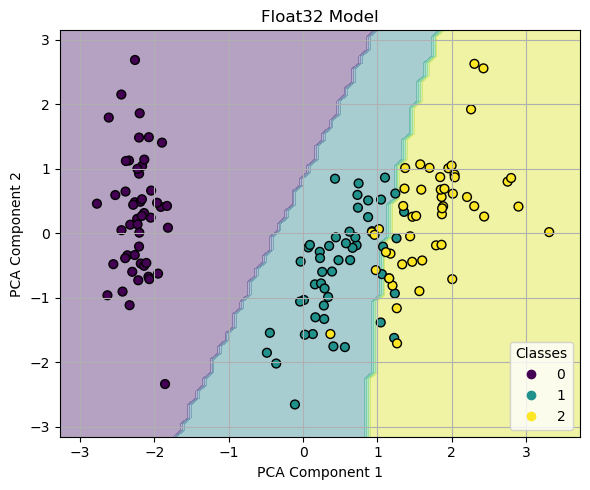

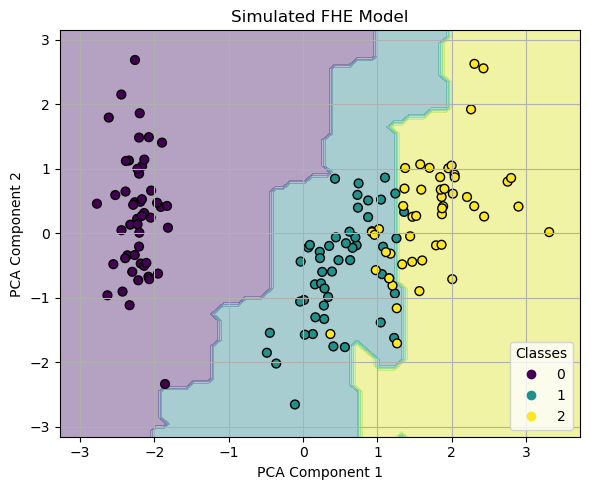

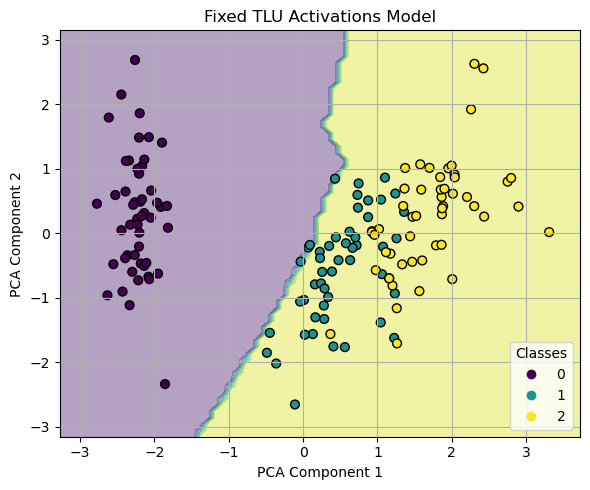

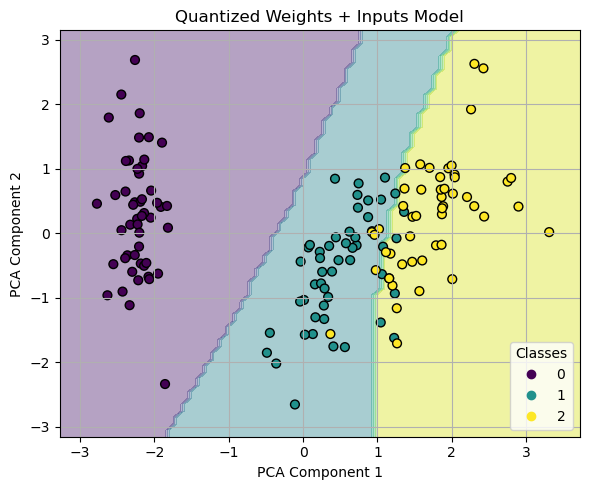

In [26]:
plot_decision_boundary_single_pca(float_model, X, y, title="Float32 Model")

plot_decision_boundary_single_pca(fhe_model, X, y, title="Simulated FHE Model", fhe_mode=True)

plot_decision_boundary_single_pca(tlu_model, X, y, title="Fixed TLU Activations Model")

plot_decision_boundary_single_pca(quantized_model, X, y, title="Quantized Weights + Inputs Model")
